In [285]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna
import seaborn as sns

In [293]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [294]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [295]:
# load in calculated expected metrics

#xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_x_predictions.csv")
xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\pfx_2022&3_xpfx.csv")

#xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_z_predictions.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\IVB_2022&3_xpfz.csv")

#xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_spin_axis_predictions.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\axis_2022&3_xaxis.csv")

xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\swing_2022&3_xswing.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\whiff_2022&3_xwhiff.csv")

xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\ld_2022&3_xld.csv")
xfoul = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\foul_2022&3_xfoul.csv")

xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\cs_2022&3_xcalledstrike.csv")

In [296]:
# rename and drop columns from expected dfs

xpfx_x = xpfx_x[['pitch_id_raw', 'xpfx_x']]
xpfx_z = xpfx_z[['pitch_id_raw', 'xpfx_z']]

xspin_axis = xspin_axis[['pitch_id_raw', 'xspin_axis']]

xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]

xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfoul = xfoul[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]

In [297]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df = df[df['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [298]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [299]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [300]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [301]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [302]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [303]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')

df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfoul, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')


# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')

df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfoul, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')

In [304]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [305]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [306]:
df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures.csv")

In [307]:
# feature selection and data splitting

columns = ['outcome', 'player_name', 'pitch_type', 'spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'xspin_axis', 'xswing', 'xwhiff', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'delta_run_exp']

features = ['spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'xspin_axis', 'xswing', 'xwhiff', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs']

# drop any rows with nan values
df = df[columns]
df = df.dropna()

# create features and targets

X = df[features]
y = df['outcome']


In [308]:
# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# optuna tuning block

def objective(trial):
    
    # define hyperparameters
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # initialize model
    
    model = xgb.XGBClassifier(**params, n_estimators=100)

    # train the model
    
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # predict on validation set
    
    y_valid_pred = model.predict_proba(X_valid)

    # calculate log loss on the validation set
    
    loss = log_loss(y_valid, y_valid_pred)

    return loss

#create an optuna study and specifcy the the direction of the optimization

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# print best parameters

print(study.best_params)

In [309]:
# set up model

model = xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)

In [310]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.547900612171408
Confusion Matrix:
[[18054     0     0    51  1237     0     2  2005   179     0    53]
 [   51     0     0    25   414     0     0   273    23     0     2]
 [   38     0     0    12   196     0     2   132    11     0     2]
 [  650     0     0   218  4164     1     2  2680   178     0    37]
 [ 1568     0     0   248  7591     0     2  4773   366     0   109]
 [   22     0     0     8   227     0     0   238     9     0     1]
 [  215     0     0    76  1418     0     1   890    80     0    18]
 [ 1905     0     0    62  2642     0     1 10805     1     0    95]
 [  621     0     0   141  2030     0     1     2   450     0    66]
 [    2     0     0     3    33     0     0    21     0     0     1]
 [  618     0     0    15   234     0     0   169    36     0   919]]


<Figure size 1000x5000 with 0 Axes>

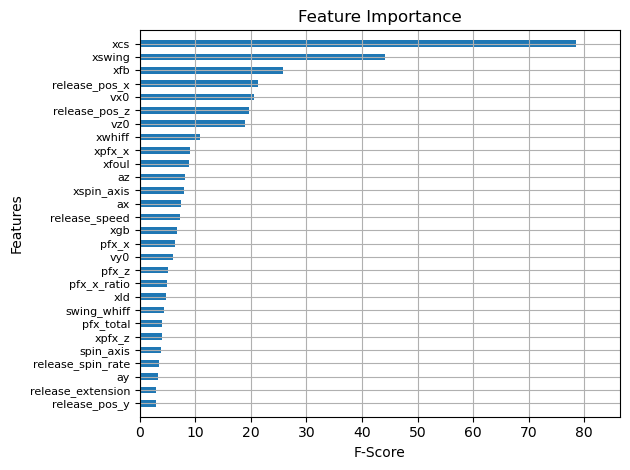

In [311]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance_fb.png', dpi=300)  # Save with high resolution
plt.show()

In [312]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xcs: 78.56117248535156
xswing: 44.07294845581055
xfb: 25.71827507019043
release_pos_x: 21.2369384765625
vx0: 20.636619567871094
release_pos_z: 19.59312629699707
vz0: 18.936954498291016
xwhiff: 10.805874824523926
xpfx_x: 8.952630043029785
xfoul: 8.8793363571167
az: 8.058521270751953
xspin_axis: 7.910948753356934
ax: 7.487959861755371
release_speed: 7.309803009033203
xgb: 6.752953052520752
pfx_x: 6.284380912780762
vy0: 6.044538974761963
pfx_z: 5.16823148727417
pfx_x_ratio: 4.978236675262451
xld: 4.706003665924072
swing_whiff: 4.418776988983154
pfx_total: 3.9948160648345947
xpfx_z: 3.989673137664795
spin_axis: 3.8447012901306152
release_spin_rate: 3.507399320602417
ay: 3.2654945850372314
release_extension: 2.971402883529663
release_pos_y: 2.9292731285095215


In [314]:
# copy and keep only features

df_2023_features = df_2023[features]

# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [315]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [316]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [317]:
# group by player name and pitch type for pitches a player threw more than 100 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 100)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
            player_name pitch_type  pitch_quality
721    Wainwright, Adam         FF       0.041832
363     Keuchel, Dallas         SI       0.039679
579  Rodriguez, Eduardo         SI       0.037348
177      Duarte, Daniel         SI       0.036645
36         Bard, Daniel         FF       0.035409
527        Patiño, Luis         SI       0.034441
731      Ward, Thaddeus         SI       0.034430
722    Wainwright, Adam         SI       0.032179
384         Lange, Alex         SI       0.030894
142     Coulombe, Danny         SI       0.030617

Bottom 10:
           player_name pitch_type  pitch_quality
120   Chapman, Aroldis         SI      -0.037173
621       Sewald, Paul         FF      -0.024204
569    Rasmussen, Drew         FF      -0.018627
414     Luzardo, Jesús         SI      -0.018280
779      deGrom, Jacob         FF      -0.015740
365     Kimbrel, Craig         FF      -0.014850
660   Strider, Spencer         FF      -0.014320
769  Woodruff, Brandon         FF     

In [324]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

,player_name,pitch_type,stuff_plus
1,"Chapman, Aroldis",SI,235
2,"Sewald, Paul",FF,196
3,"Rasmussen, Drew",FF,180
4,"Luzardo, Jesús",SI,179
5,"deGrom, Jacob",FF,171
6,"Kimbrel, Craig",FF,168
7,"Strider, Spencer",FF,167
8,"Woodruff, Brandon",FF,163
9,"Vesia, Alex",FF,161
10,"Fairbanks, Pete",FF,159


In [319]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Fastball Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_fb_v6.png', dpi=300)
plt.close()

In [ ]:
# save 2022 and 2023 dfs to y drive

df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures_outcome_probs_stuff_plus.csv")
df_2023.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_MLB_xfeatures__outcome_probs_stuff_plus.csv")

In [326]:
# heater avg metrics function for breaking ball model

def heater_stats(df):
    grouped_df = df.groupby(['player_name', 'pitch_type'])[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'xpfx_x', 'pfx_z', 'xpfx_z', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'release_spin_rate', 'release_extension', 'spin_axis']].mean().reset_index()
    idx = grouped_df.groupby(['player_name'])['release_speed'].transform(max) == grouped_df['release_speed']
    heater_df = grouped_df[idx]
    heater_df = heater_df.groupby('player_name').head(1).reset_index(drop=True)
    final_df = heater_df.rename(columns={col: f'fb_{col}' if col != 'player_name' else col for col in heater_df.columns})
    return final_df

heaters_2022 = heater_stats(df)

heaters_2022[heaters_2022['player_name'] == 'Sewald, Paul']

,player_name,fb_pitch_type,fb_release_speed,fb_release_pos_x,fb_release_pos_z,fb_pfx_x,fb_xpfx_x,fb_pfx_z,fb_xpfx_z,fb_ax,fb_ay,fb_az,fb_vx0,fb_vy0,fb_vz0,fb_release_spin_rate,fb_release_extension,fb_spin_axis
646,"Sewald, Paul",FF,92.52976,-3.701701,4.425841,-0.978466,-0.895004,1.136044,1.10682,-14.241362,28.674183,-18.501122,11.140678,-134.308777,-0.540023,2492.87061,6.538447,119.54159


In [321]:
# group by pitcher and pitch type

pp = df_2023.groupby(['player_name', 'pitch_type'])

# calculate sum of delta run expectancy and count of pitches for each pitcher's pitch

rv = pp.agg(total_delta_run_exp=('delta_run_exp', 'sum'),
                      total_pitches=('delta_run_exp', 'count'))

# calculate run value per 100 pitches

rv['run_value_per_100_pitches'] = (rv['total_delta_run_exp'] / rv['total_pitches']) * 100

# filter for pitches thrown at least 100 times and sort

rv = rv[rv['total_pitches'] > 100]
rv = rv.sort_values(by='run_value_per_100_pitches')

# merge with sorted pitch quality sum on player name and pitch type

model_validation_df = pd.merge(sorted_pitch_quality_sum, rv, on=['player_name', 'pitch_type'], how='left')

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


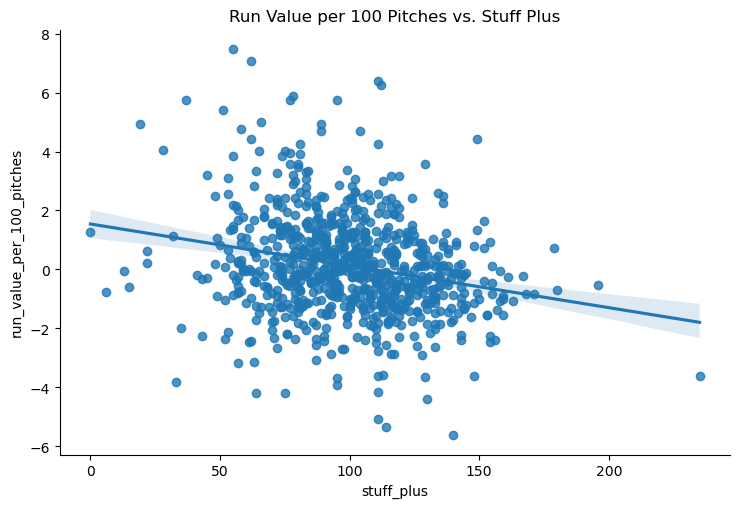

In [322]:
# scatter plot with a regression line

sns.lmplot(x='stuff_plus', y='run_value_per_100_pitches', data=model_validation_df, aspect=1.5)
plt.title('Run Value per 100 Pitches vs. Stuff Plus')
plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\validation_01.png', dpi=300)
plt.savefig('run_value_validation_plot.png', dpi=300)
plt.show()

In [323]:
# correlation coefficient

correlation = model_validation_df['stuff_plus'].corr(model_validation_df['run_value_per_100_pitches'])
print(f"Correlation Coefficient: {correlation}")


from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

slope, intercept, r_value, p_value, std_err = stats.linregress(model_validation_df['stuff_plus'], model_validation_df['run_value_per_100_pitches'])
predicted_values = slope * model_validation_df['stuff_plus'] + intercept

# mse and rmse

mse = mean_squared_error(model_validation_df['run_value_per_100_pitches'], predicted_values)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# rsquared

r_squared = r2_score(model_validation_df['run_value_per_100_pitches'], predicted_values)
print(f"R-squared: {r_squared}")

Correlation Coefficient: -0.2341024800962197
Mean Squared Error: 2.7599564810287522
Root Mean Squared Error: 1.6613116748607868
R-squared: 0.05480397118720093
